# Import

In [308]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input
from tensorflow.keras.callbacks import EarlyStopping
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import optuna
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from pmdarima.arima import StepwiseContext
import os
import holidays
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


#Save requirements
os.system("pip freeze > requirements.txt")

#SEED   
np.random.seed(42)
tf.random.set_seed(42)

In [309]:
df = pd.read_csv('Data/london_merged.csv')
display(df.head(2))

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0


- Metadata:
  - "timestamp" - timestamp field for grouping the data
  - "cnt" - the count of a new bike shares
  - "t1" - real temperature in C
  - "t2" - temperature in C "feels like"
  - "hum" - humidity in percentage
  - "wind_speed" - wind speed in km/h
  - "weather_code" - category of the weather
  - "is_holiday" - boolean field - 1 holiday / 0 non holiday
  - "is_weekend" - boolean field - 1 if the day is weekend
  - "season" - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.
  - "weathe_code" category description:
     - 1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 
     - 2 = scattered clouds / few clouds 
     - 3 = Broken clouds 
     - 4 = Cloudy 
     - 7 = Rain/ light Rain shower/ Light rain 
     - 10 = rain with thunderstorm 
     - 26 = snowfall 
     - 94 = Freezing Fog

In [310]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


# Data Wrangling

In [311]:
#Convert the timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
#Keep records from 2015 and 2016
df = df[(df['timestamp'].dt.year == 2015) | (df['timestamp'].dt.year == 2016)]
#Sort the values by timestamp
df = df.sort_values('timestamp')

In [312]:
#Missing values
df.isnull().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

- No missing values. But there might be missing timestamps.

In [313]:
#Check for missing timestamps
all_days = pd.date_range(start=df['timestamp'].min(), end=df['timestamp'].max(), freq='h')
missing_days = all_days[~all_days.isin(df['timestamp'])]
print('Number of missing timestamps:', len(missing_days))

Number of missing timestamps: 130


In [314]:
missing_days[0]

Timestamp('2015-01-07 19:00:00')

- 130 timestamps are missing. We will imput them using existing values.

In [315]:
#London holidays
uk_holidays = holidays.UK(years=[df['timestamp'].dt.year.min(), df['timestamp'].dt.year.max()])
uk_holidays

{datetime.date(2016, 3, 25): 'Good Friday', datetime.date(2016, 5, 2): 'May Day', datetime.date(2016, 5, 30): 'Spring Bank Holiday', datetime.date(2016, 1, 1): "New Year's Day", datetime.date(2016, 12, 25): 'Christmas Day', datetime.date(2016, 12, 27): 'Christmas Day (observed)', datetime.date(2016, 12, 26): 'Boxing Day', datetime.date(2015, 4, 3): 'Good Friday', datetime.date(2015, 5, 4): 'May Day', datetime.date(2015, 5, 25): 'Spring Bank Holiday', datetime.date(2015, 1, 1): "New Year's Day", datetime.date(2015, 12, 25): 'Christmas Day', datetime.date(2015, 12, 26): 'Boxing Day', datetime.date(2015, 12, 28): 'Boxing Day (observed)'}

In [316]:
#Create new dataframe using all days
df_full = pd.DataFrame(all_days, columns=['timestamp'])
#Merge with df to get cnt, t1, t2, hum, wind_speed, weather_code, season
df_full = df_full.merge(df[['timestamp', 'cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'season']], on='timestamp', how='left')
#is_holiday column: 1 if holiday, 0 if not
df_full['is_holiday'] = np.where(df_full['timestamp'].dt.date.isin(uk_holidays), 1, 0)
df_full['is_weekend'] = np.where(df_full['timestamp'].dt.dayofweek.isin([5, 6]), 1, 0)

#Backfill missing values
df_full = df_full.ffill()
df = df_full.copy()

In [317]:
df.isnull().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
season          0
is_holiday      0
is_weekend      0
dtype: int64

In [318]:
missing_days = all_days[~all_days.isin(df['timestamp'])]
print('Number of missing timestamps:', len(missing_days))

Number of missing timestamps: 0


In [319]:
#Set the timestamp as the index
df.set_index('timestamp', inplace=True)
#Set period to 1 hour
df.index = pd.DatetimeIndex(df.index).to_period('h')
df.head(2)

,cnt,t1,t2,hum,wind_speed,weather_code,season,is_holiday,is_weekend
timestamp,,,,,,,,,
2015-01-04 00:00,182.0,3.0,2.0,93.0,6.0,3.0,3.0,0,1
2015-01-04 01:00,138.0,3.0,2.5,93.0,5.0,1.0,3.0,0,1


In [320]:
df = df.resample('D').agg({'cnt':'sum', 
                           't1':'median', 
                           't2':'median', 
                           'hum':'median', 
                           'wind_speed':'median', 
                           'weather_code': lambda x: x.value_counts().index[0], 
                           'season': lambda x: x.value_counts().index[0], 
                           'is_holiday':'max', 
                           'is_weekend':'max'})
df.head(2)

C:\Users\TUF\AppData\Local\Temp\ipykernel_218980\2112590929.py:1: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  df = df.resample('D').agg({'cnt':'sum',


,cnt,t1,t2,hum,wind_speed,weather_code,season,is_holiday,is_weekend
timestamp,,,,,,,,,
2015-01-04,9234.0,2.75,0.00,93.0,7.0,3.0,3.0,0,1
2015-01-05,20372.0,9.00,7.25,81.5,8.5,3.0,3.0,0,0


In [321]:
#Remove duplicates
df.drop_duplicates(inplace=True)

Index(['cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'season',
       'is_holiday', 'is_weekend'],
      dtype='object')
t1
t2
hum
wind_speed
weather_code
season
is_holiday
is_weekend


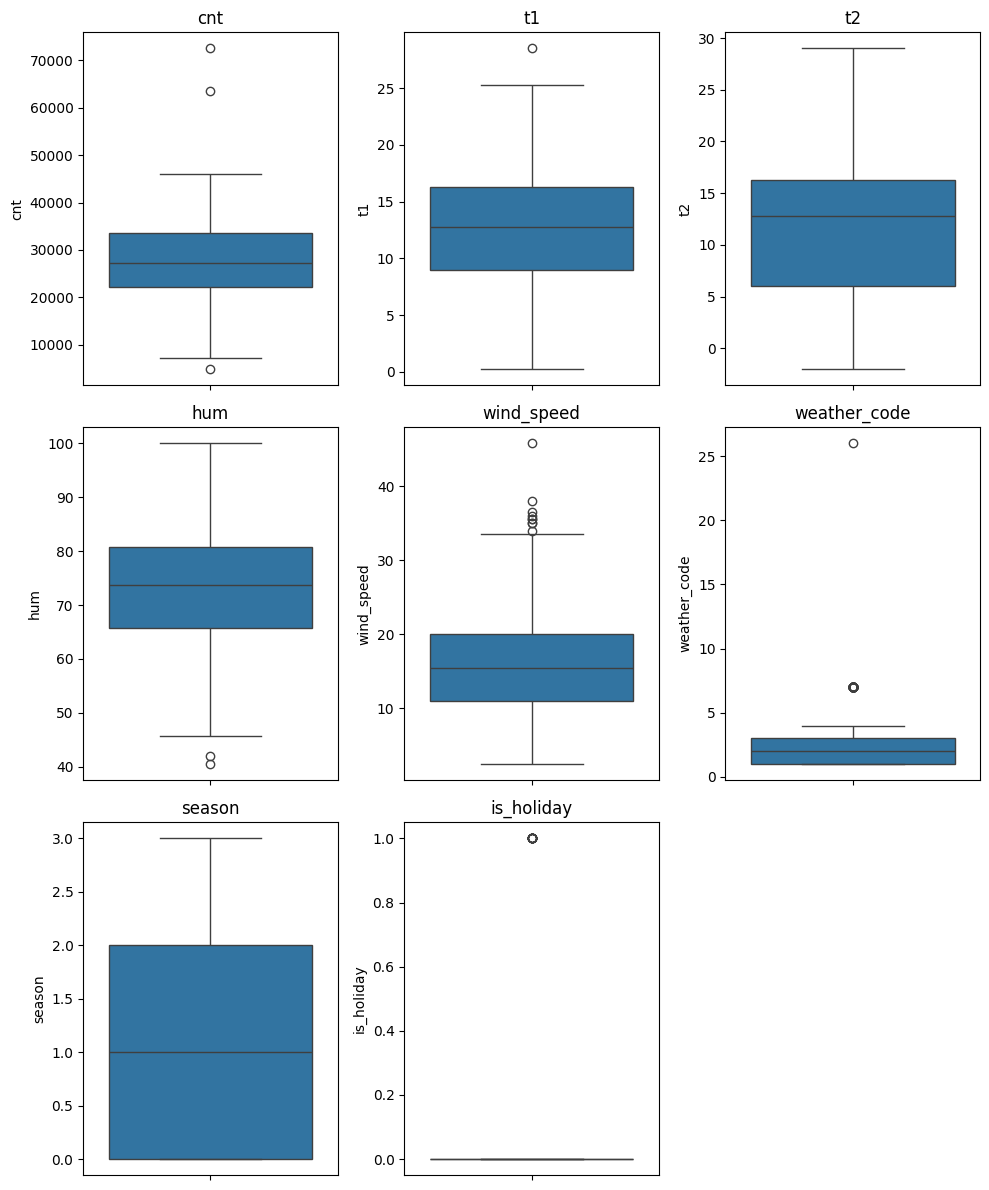

In [322]:
# # Boxplot of all the columns
plt.figure(figsize=(10, 12))
cols = df.columns
print(cols)
for i in range(1, len(cols)):
    print(cols[i])
    plt.subplot(3, 3, i)
    sns.boxplot(df[cols[i-1]])
    plt.title(cols[i-1])
plt.tight_layout()
plt.show()

- There is no abnormal data in the dataset.

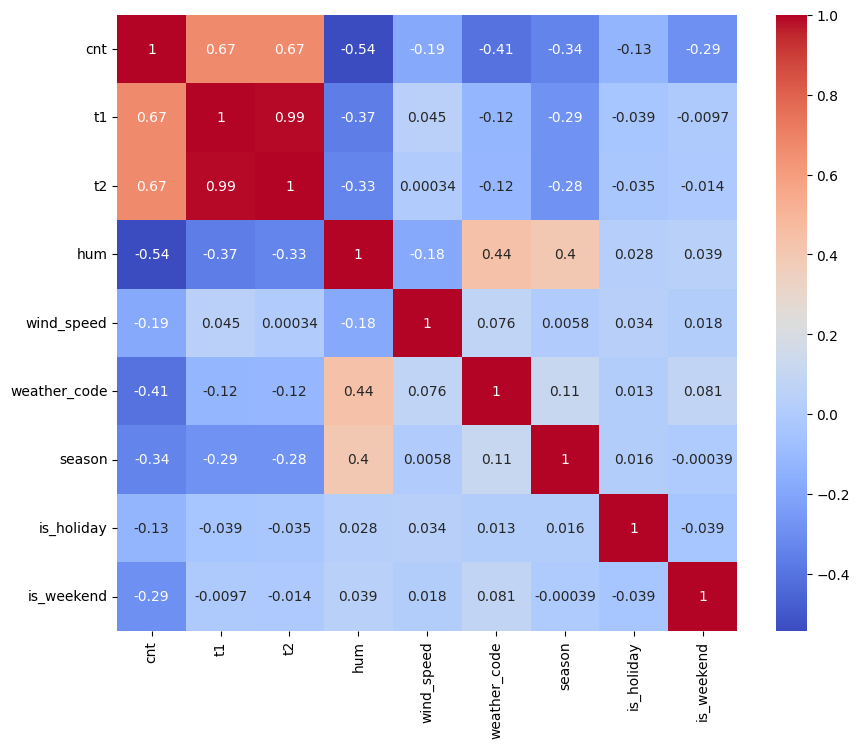

In [323]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

- Real and feels like temperature are highly correlated. Let's use feels like temperature since it is more likely to impact the decision.
- Humidity is also correlated with temperature. We will drop it.

In [324]:
#Drop t1
df.drop(['t1', 'hum'], axis=1, inplace=True)

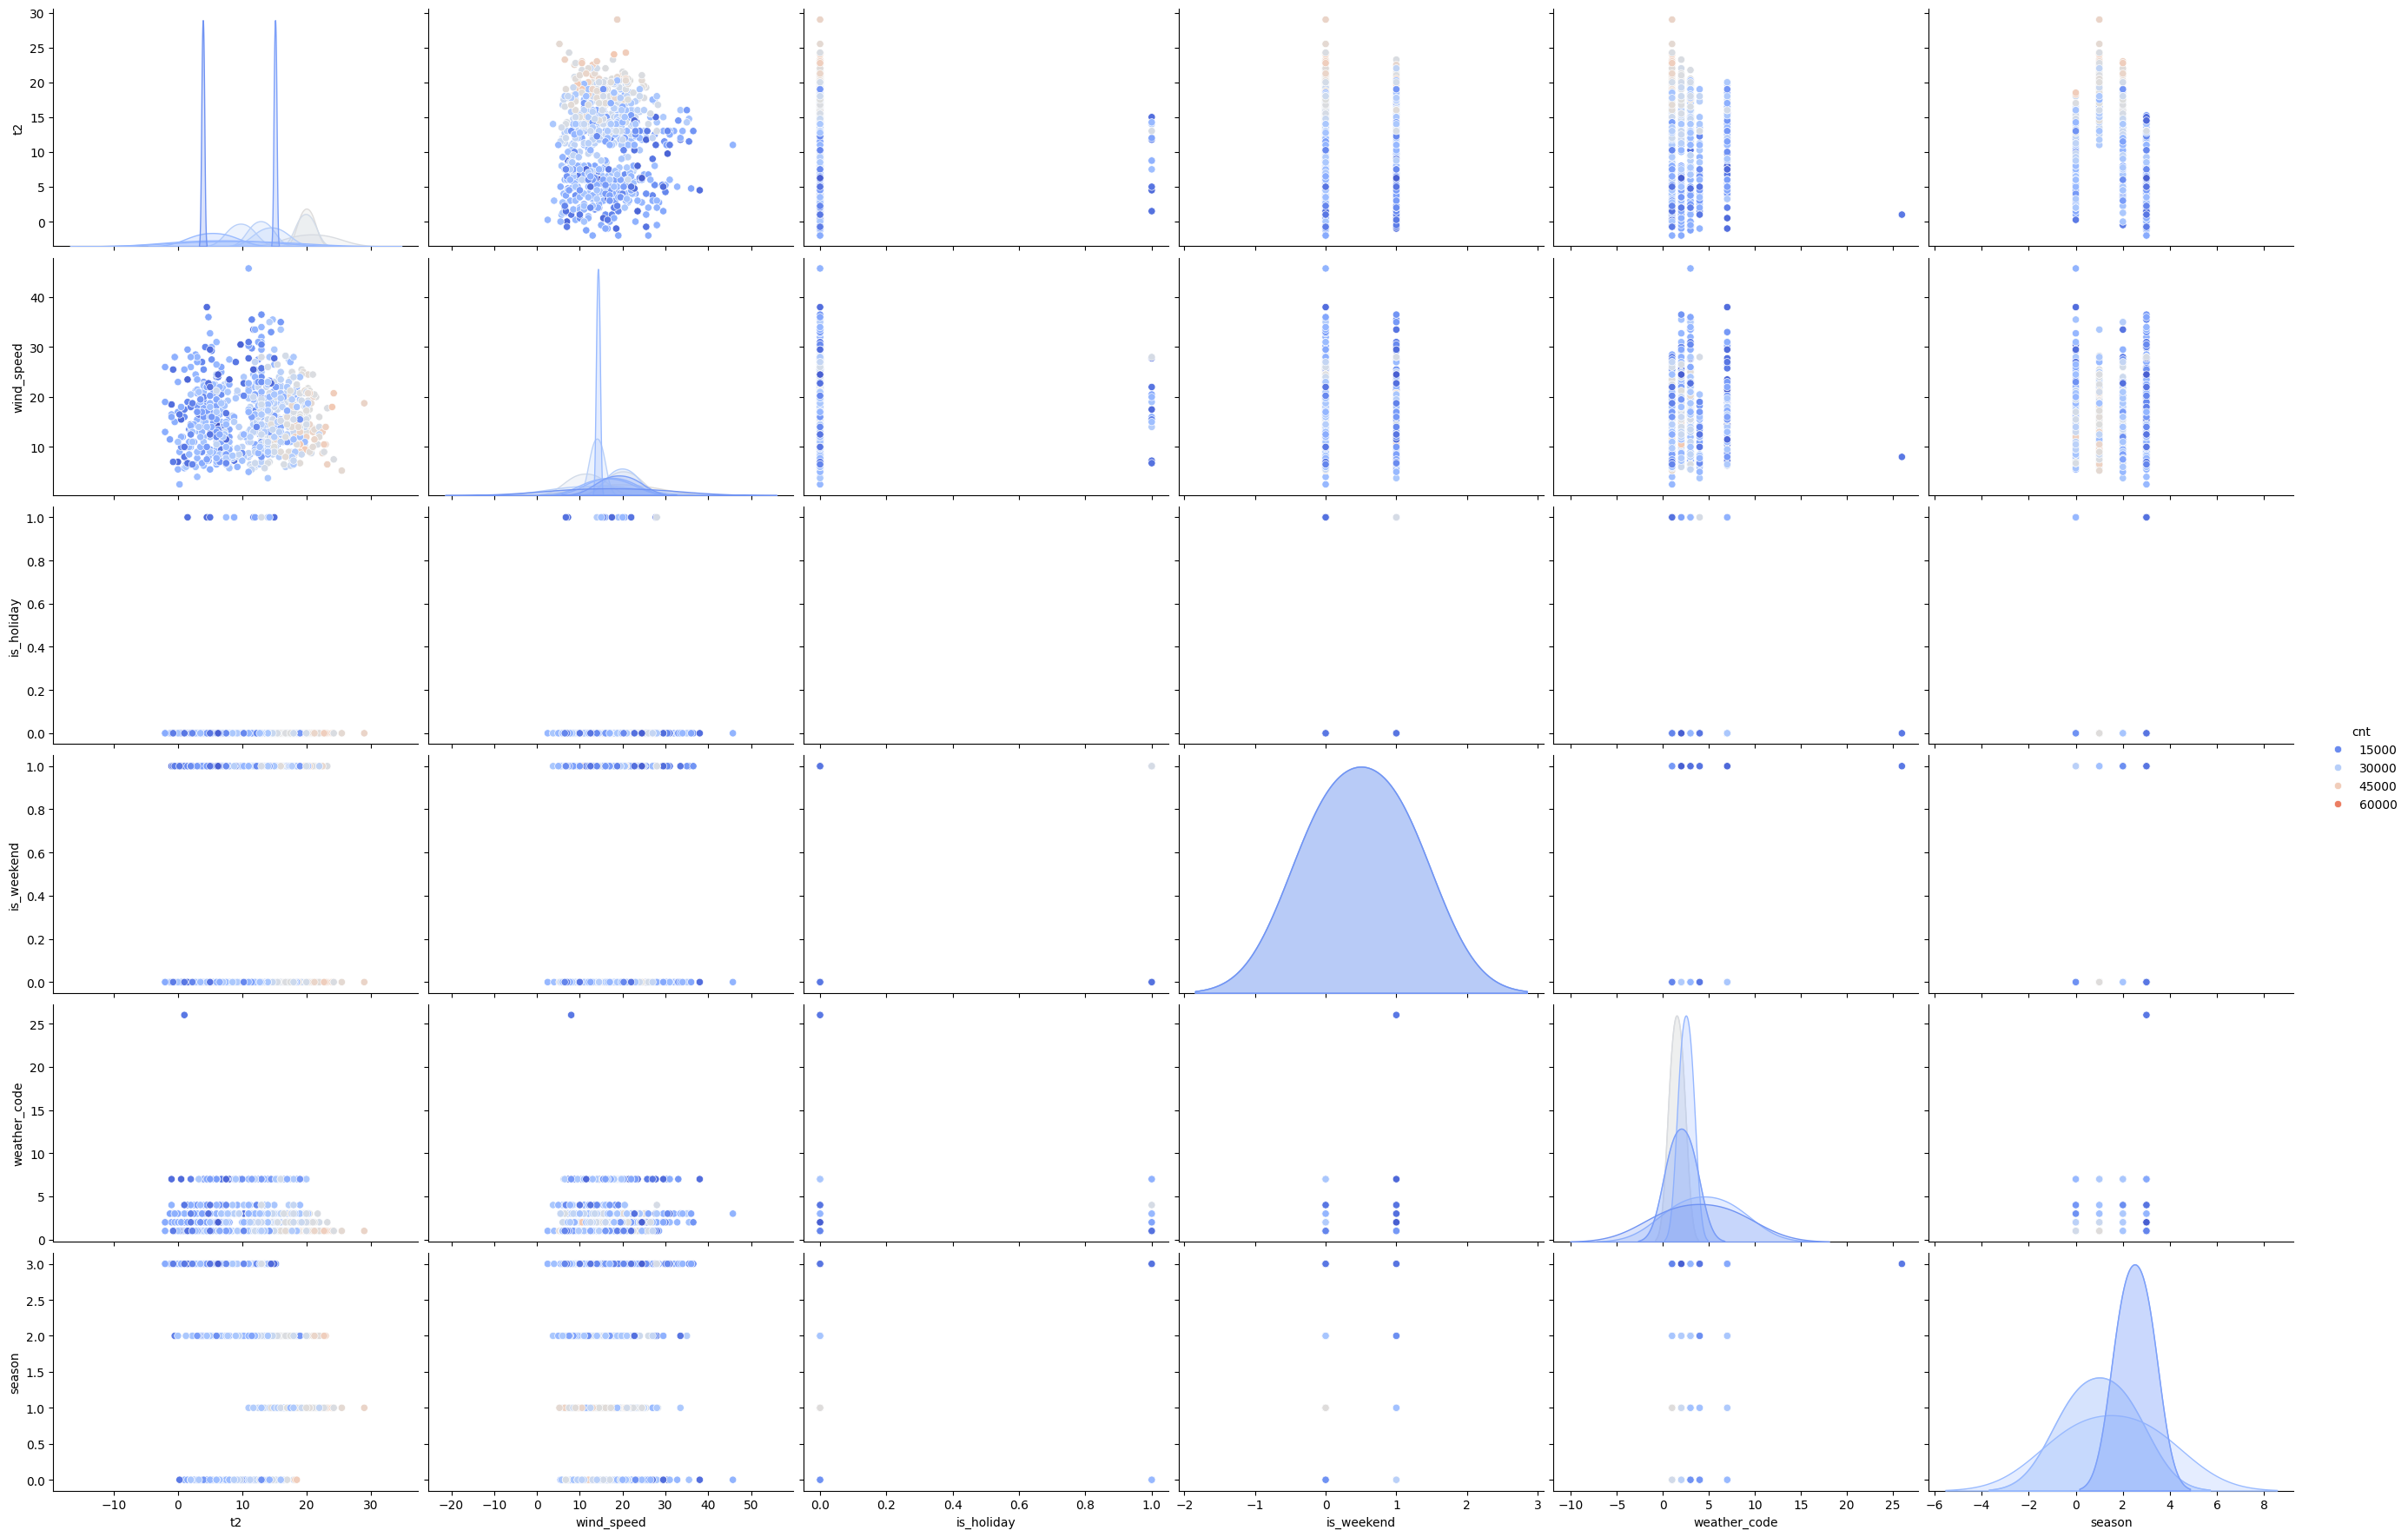

In [325]:
# #Pairplot
sns.pairplot(df[['cnt', 't2', 'wind_speed', 'is_holiday', 'is_weekend', 'weather_code',
                  'season',
                  ]],
             hue='cnt', 
             palette='coolwarm',
             height=3,
             aspect=1.5)
plt.show()

In [326]:
#Map codes
#Map weather code:
weather_desc = {
    1: 'Clear', 2: 'Scattered_Clouds', 3: 'Broken_Clouds', 4: 'Cloudy', 7: 'Rain', 10: 'Storm', 26: 'Snowfall', 94: 'Freezing_Fog'
}
df['weather_code'] = df['weather_code'].map(weather_desc)

# #Map is_holiday:
# df['is_holiday'] = df['is_holiday'].map({0:'No_Holiday', 1:'Holiday'})

# #Map is_weekend:
# df['is_weekend'] = df['is_weekend'].map({0:'Weekday', 1:'Weekend'})

#Map season:
seasons = {0:'Spring', 1:'Summer', 2:'Fall', 3:'Winter'}
df['season'] = df['season'].map(seasons)
df.head(2)

,cnt,t2,wind_speed,weather_code,season,is_holiday,is_weekend
timestamp,,,,,,,
2015-01-04,9234.0,0.00,7.0,Broken_Clouds,Winter,0,1
2015-01-05,20372.0,7.25,8.5,Broken_Clouds,Winter,0,0


In [327]:
#One hot encoding for categorical variables
df = pd.get_dummies(df, drop_first=True, dtype=int)
df.head(2)

,cnt,t2,wind_speed,is_holiday,is_weekend,weather_code_Clear,weather_code_Cloudy,weather_code_Rain,weather_code_Scattered_Clouds,weather_code_Snowfall,season_Spring,season_Summer,season_Winter
timestamp,,,,,,,,,,,,,
2015-01-04,9234.0,0.00,7.0,0,1,0,0,0,0,0,0,0,1
2015-01-05,20372.0,7.25,8.5,0,0,0,0,0,0,0,0,0,1


In [328]:
# Add month sine and cosine columns
df['month_sin'] = np.sin(2*np.pi*df.index.month/12)
df['month_cos'] = np.cos(2*np.pi*df.index.month/12)

In [329]:
#Training df till June 2016 and testing df from July 2016
train_df = df.loc[:'2016-06-30'].copy()
test_df = df.loc['2016-07-01':].copy()

In [330]:
#In case some models need validation set, split train_df to get validation set. Use validation from April 2016 to June 2016. 
train_train_df = train_df.loc[:'2016-03-31'].copy()
val_df = train_df.loc['2016-04-01':].copy()

# Diagnosis

### Check for seasonality

<Day>


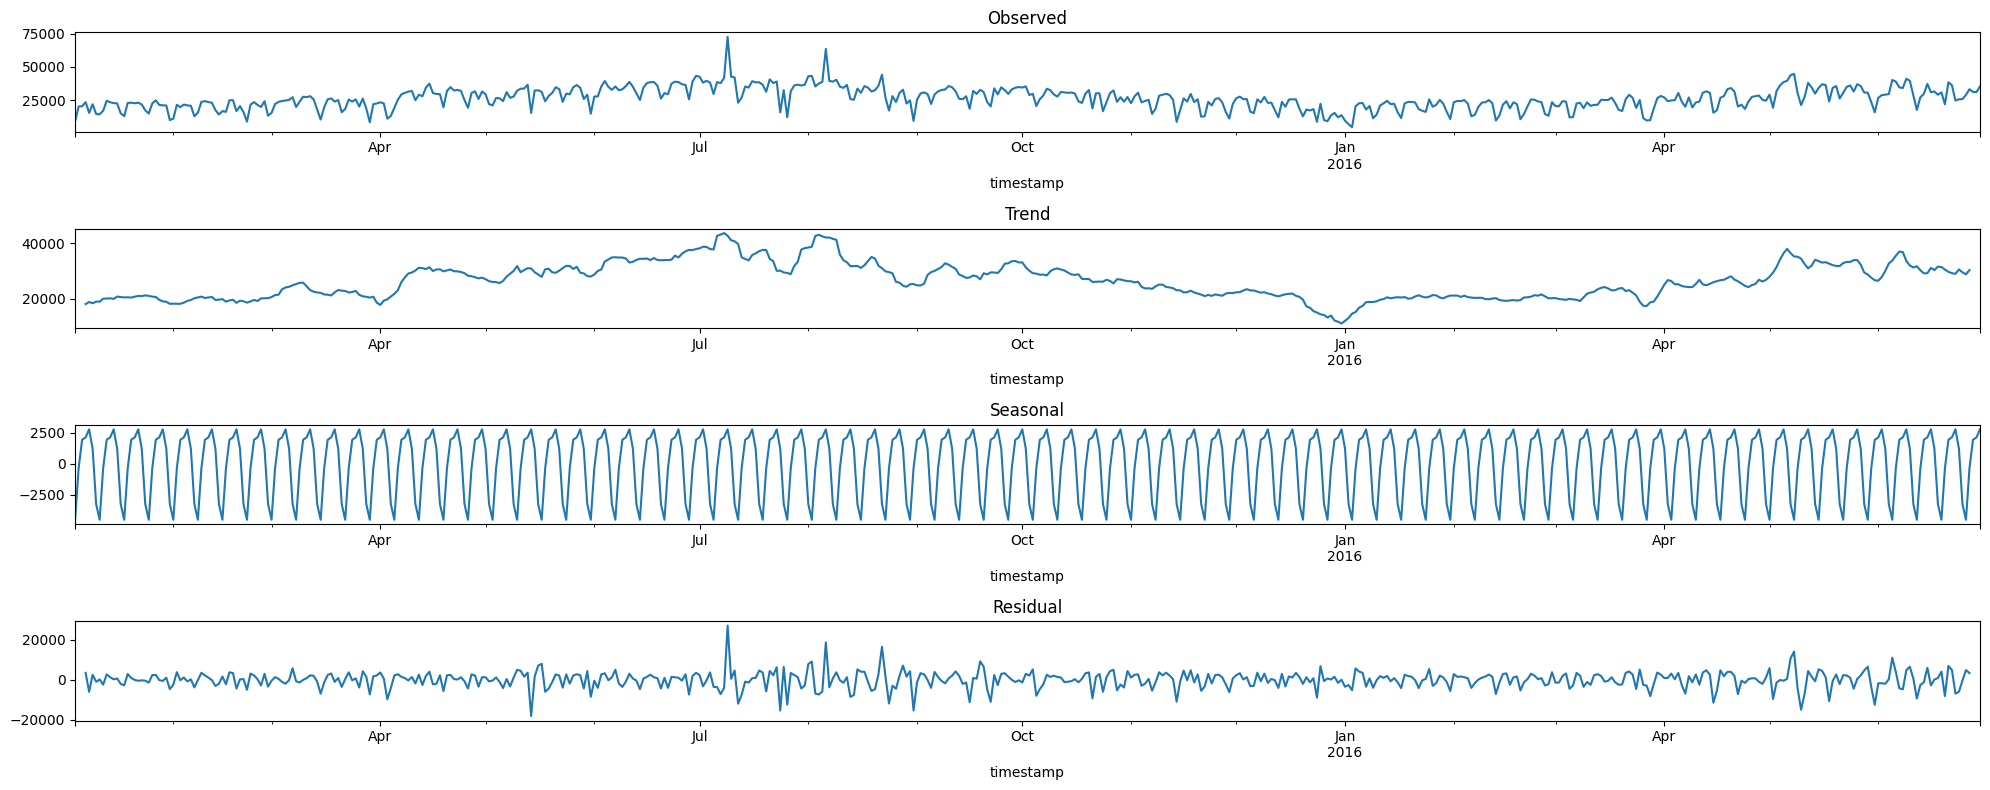

In [331]:
#Plot seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

fig_df = train_df.copy()
fig_df = fig_df.asfreq('D')
fig_df.index = pd.DatetimeIndex(fig_df.index.to_timestamp())
print(fig_df.index.freq)
fig, axes = plt.subplots(4, 1, figsize=(20, 8))
seasonal_decompose = seasonal_decompose(fig_df['cnt'], model='additive')
seasonal_decompose.observed.plot(ax=axes[0], title='Observed')
seasonal_decompose.trend.plot(ax=axes[1], title='Trend')
seasonal_decompose.seasonal.plot(ax=axes[2], title='Seasonal')
seasonal_decompose.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()
plt.show()

There is clear seasonality in the data. Also, the data does not look stationary.

### Check for stationarity

In [332]:
def check_stationarity(data):
    print('Null Hypothesis: Presence of unit root (Data is not stationary)')
    print('Alternate Hypothesis: Absence of unit root (Data is stationary)')
    result = adfuller(data, autolag='AIC')
    print(result)
    print('ADF Statistic:', result[0])
    print('Lags: ')
    print('p-value:', result[1])
    if result[1] > 0.05:
        print('Data is not stationary')
    else:
        print('Data is stationary')

check_stationarity(train_df['cnt'])

Null Hypothesis: Presence of unit root (Data is not stationary)
Alternate Hypothesis: Absence of unit root (Data is stationary)
(-2.134764140765684, 0.2307674088038229, 14, 529, {'1%': -3.442772146350605, '5%': -2.8670191055991836, '10%': -2.5696881663873414}, 10503.323249600502)
ADF Statistic: -2.134764140765684
Lags: 
p-value: 0.2307674088038229
Data is not stationary


Hence, the models to be used should be able to handle seasonality and non-stationarity. SARIMAX might be a good choice. However, there are multiple seasonalities in the data which might be difficult to capture with SARIMAX. We will use Facebook Prophet and LSTM for this task. Let's still try SARIMAX and see how it performs.

# Models

## SARIMAX

- We will use Auto ARIMA to find the best parameter and not rely only on the ACF and PACF plots. However, ACF and PACF plots are useful to define the search space for Auto ARIMA. It is to note that Auto Arima leads to memory issue for high order models. Therefore, we will limit the search space.

In [ ]:
#Standardize the data
scaler = MinMaxScaler()
X_train = train_df.drop('cnt', axis=1)
y_train = train_df['cnt']

X_test = test_df.drop('cnt', axis=1)
y_test = test_df['cnt']

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#Auto ARIMA
with StepwiseContext(max_dur=600):
    model = auto_arima(y=y_train,
                        X=X_train_scaled,
                        start_p=2,
                        d=None,
                        start_q=2,
                        max_p=3,
                        max_d=7,
                        max_q=3,
                        start_P=4,
                        D=None,
                        start_Q=0,
                        m=52,
                        max_P=5,
                        max_D=7,
                        max_Q=5,
                        stationary=False,
                        seasonal=True,
                        stepwise = False,
                        random=True,
                        random_state=42,
                        njobs=-1,
                        scoring='mae',
                        maxiter=1000,
                        trace=True,
                        )
    print(model.summary())

In [ ]:
#Predictions
y_pred = model.predict(n_periods=len(y_test), X=X_test_scaled)
y_pred = pd.Series(y_pred, index=y_test.index)

#RMSE, MAE, MAPE, R2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)
print('RMSE:', rmse)
print('MAE:', mae)
print('MAPE:', mape)
print('R2:', r2)

#Plot actual vs predicted
plt.figure(figsize=(20, 6))
# plt.plot(y_train.index.to_timestamp(), y_train, label='Train')
plt.plot(y_test.index.to_timestamp(), y_test, label='Actual')
plt.plot(y_test.index.to_timestamp(), y_pred, label='Predicted')
plt.xticks(rotation=90)
plt.legend()
plt.show()

# XGBoost

In [ ]:
# XGBoost
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_train = train_train_df.drop(['cnt'], axis=1)
y_train = train_train_df['cnt']

X_val = val_df.drop(['cnt'], axis=1)
y_val = val_df['cnt']

X_test = test_df.drop(['cnt'], axis=1)
y_test = test_df['cnt']

#Standardize the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#XGBoost tuning using optuna
def xgboost_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1010, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 40),
        'learning_rate': trial.suggest_float('learning_rate', 0.00001, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0, step=0.1),
        'random_state': 42
    }
    
    model = XGBRegressor(verbosity=1, **params)
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_val_scaled)
    return mean_absolute_error(y_val, y_pred)

study_name = 'xgboost_study'
#Delete the study if it exists
try:
    optuna.delete_study(study_name = study_name, storage=f'sqlite:///{study_name}.db')
except:
    pass
storage = f'sqlite:///{study_name}.db'
study = optuna.create_study(study_name=study_name, storage=storage, load_if_exists=True, sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(xgboost_objective, n_trials=100, n_jobs=5, show_progress_bar=True)

In [ ]:
# Best parameters
best_params = study.best_params
print('Best parameters:', best_params)

#Train the model with best parameters
model = XGBRegressor(verbosity=1, **best_params)
model.fit(X_train_scaled, y_train)

#Predict on test set
y_pred = model.predict(X_test_scaled)
#RMSE, MAE, MAPE, R2
rmse = np.sqrt(np.mean((y_test - y_pred)**2))
mae = np.mean(np.abs(y_test - y_pred))
r2 = 1 - (np.sum((y_test - y_pred)**2) / np.sum((y_test - y_test.mean())**2))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('RMSE:', rmse)
print('MAE:', mae)
print('R2:', r2)
print('MAPE:', mape)

#Plot predictions vs actual
plt.figure(figsize=(20, 6))
plt.plot(train_df.index.to_timestamp(), train_df['cnt'], label='Train')
plt.plot(test_df.index.to_timestamp(), test_df['cnt'], label='Test')
plt.plot(test_df.index.to_timestamp(), y_pred, label='Predictions')
plt.title('Bike Rentals')
plt.xlabel('Date')
plt.ylabel('Number of Rentals')
plt.legend()
plt.show()

# Prophet

In [ ]:
pro_train_df = train_df.copy()
pro_train_df.reset_index(inplace=True)
pro_train_df.rename(columns={'timestamp':'ds', 'cnt':'y'}, inplace=True)
pro_train_df['ds'] = pro_train_df['ds'].dt.to_timestamp()

model = Prophet(weekly_seasonality=True, growth='flat', yearly_seasonality=True, interval_width=0.95, scaling='minmax')
#Add holiday regressor
model.add_country_holidays(country_name='UK')
model.add_regressor('t2')
model.add_regressor('wind_speed')
model.add_regressor('is_holiday')
model.add_regressor('is_weekend')
model.add_regressor('weather_code_Clear')
model.add_regressor('weather_code_Cloudy')
model.add_regressor('weather_code_Rain')
model.add_regressor('weather_code_Scattered_Clouds')
model.add_regressor('weather_code_Snowfall')
model.add_regressor('season_Spring')
model.add_regressor('season_Summer')
model.add_regressor('season_Winter')
# model.add_regressor('month_sin')
# model.add_regressor('month_cos')

model.fit(pro_train_df)

#Predict on test set
pro_test_df = test_df.copy()
pro_test_df.reset_index(inplace=True)
pro_test_df.rename(columns={'timestamp':'ds', 'cnt':'y'}, inplace=True)
pro_test_df['ds'] = pro_test_df['ds'].dt.to_timestamp()

y_pred = model.predict(pro_test_df)
# model.plot_components(y_pred)
# plt.show()
y_pred.set_index('ds', inplace=True)

In [ ]:
#RMSE, MAE, R2, MAPE
rmse = np.sqrt(mean_squared_error(test_df['cnt'], y_pred['yhat']))
mae = mean_absolute_error(test_df['cnt'], y_pred['yhat'])
r2 = r2_score(test_df['cnt'], y_pred['yhat'])
mape = np.mean(np.abs((test_df.to_timestamp()['cnt'] - y_pred['yhat']) / test_df.to_timestamp()['cnt'])) * 100
print('RMSE:', rmse)
print('MAE:', mae)
print('R2:', r2)
print('MAPE:', mape)

#Plot predictions vs actual with confidence intervals
plt.figure(figsize=(20, 6))
plt.plot(train_df.index.to_timestamp(), train_df['cnt'], label='Train')
plt.plot(test_df.index.to_timestamp(), test_df['cnt'], label='Test')
plt.plot(test_df.index.to_timestamp(), y_pred['yhat'], label='Predictions')
plt.fill_between(test_df.index.to_timestamp(), y_pred['yhat_lower'], y_pred['yhat_upper'], color='gray', alpha=0.2)
plt.title('Bike Rentals')
plt.xlabel('Date')
plt.ylabel('Number of Rentals')
plt.legend()
plt.show()


# LSTM

In [333]:
#Import LSTM from keras
#Clean previous model
tf.keras.backend.clear_session()

#LSTM with lookback window of 7 days and 7 days forecast
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 7
X_train, y_train = create_dataset(train_df, train_df['cnt'], time_steps)
X_test, y_test = create_dataset(test_df, test_df['cnt'], time_steps)

#Reshape the data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

#LSTM model
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mae')
model.summary()

#Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)

#Fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[es], verbose=1)

#Predictions
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(y_pred.shape[0])

#RMSE, MAE, R2
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('RMSE:', rmse)
print('MAE:', mae)
print('R2:', r2)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 128)         │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,201 (481.25 KB)

 Trainable params: 123,201 (481.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 25793.1270 - val_loss: 28526.3613
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 25788.9277 - val_loss: 28523.2832
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25786.0254 - val_loss: 28520.5469
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 25783.4297 - val_loss: 28518.7988
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 25781.7578 - val_loss: 28517.5488
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25780.5215 - val_loss: 28516.4375
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25779.5215 - val_loss: 28515.3750
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25778.4473 - val_loss: 28514.3457
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25777.5605 - val_loss: 28513.3398
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25776.2344 - val_loss: 28512.3418
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25775.48

In [ ]:
y_pred